This notebook showcases how the data for pytorch captioning tutorial was originally obtained.

Running this script is not necessary to complete the basic assignment as __you will be given preprocessed data__ produced by this notebook. The script itself takes hours

However, if one wants to implement e.g. attentive captioning with attention casted into earlier layers in the network OR try a different network architecture, one is invited to change this code at will. 
GPU(s), high-speed internet and at least ~60G of disk space are recommended.
40Gb of disk space are required.

In [1]:
# Obtaining the data:
# download stuff from http://cocodataset.org/#download
!curl http://images.cocodataset.org/zips/train2017.zip > train2017.zip
!curl http://images.cocodataset.org/zips/val2017.zip > val2017.zip
!curl http://images.cocodataset.org/annotations/annotations_trainval2017.zip > annotations_trainval2017.zip

!unzip annotations_trainval2017.zip
!unzip train2017.zip > log
!unzip val2017.zip > log

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.0G  100 18.0G    0     0  9516k      0  0:33:04  0:33:04 --:--:-- 9062k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  777M  100  777M    0     0  1618k      0  0:08:11  0:08:11 --:--:-- 1655k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  241M  100  241M    0     0  1919k      0  0:02:08  0:02:08 --:--:-- 3949k
Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2

In [2]:
# sanity check
!du -h --max-depth=1 .

544K	./.ipynb_checkpoints
788M	./val2017
19G	./train2017
796M	./annotations
39G	.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#%env CUDA_VISIBLE_DEVICES=0
import torch, torch.nn as nn
import torch.nn.functional as F

In [5]:
# you may need to install pycocotools, nltk, h5py, tqdm
#!pip install pycocotools nltk h5py tqdm
import sys
!{sys.executable} -m pip install pycocotools nltk h5py tqdm

In [6]:
import h5py
from tqdm import tqdm

In [7]:
from torchvision.datasets import coco
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])
coco_train = coco.CocoCaptions("./train2017/", "./annotations/captions_train2017.json", transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=coco_train, batch_size=32, shuffle=False, num_workers=4)

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


In [8]:
# If you have not much space on the disk, you may delete zipped archives now:
# !rm annotations_trainval2017.zip
# !rm train2017.zip
# !rm val2017.zip

In [9]:
from torch import nn
import torch.nn.functional as F
from torchvision.models.vgg import VGG, cfgs as VGG_cfgs, make_layers
from warnings import warn
class BeheadedVGG19(VGG):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        x_for_attn = x= self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = x = self.classifier(x)
        return x_for_attn, logits

features_net = BeheadedVGG19(make_layers(VGG_cfgs['E'], batch_norm=False), init_weights=False)

from torch.utils.model_zoo import load_url
features_net_url = 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'
features_net.load_state_dict(load_url(features_net_url))

features_net = features_net.train(False)
if torch.cuda.is_available():
    features_net = features_net.cuda()
features_net = nn.DataParallel(features_net)

# Sanity check

Test-run NN over one batch. NN labels shouldn't be completely absurd.

NN shapes
before_pool: (32, 512, 9, 9)
logits: (32, 1000)
# 0


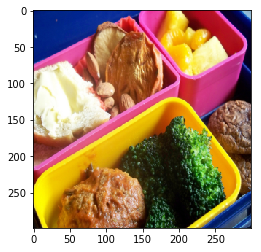

Captions
('Closeup of bins of food that include broccoli and bread.', 'A meal is presented in brightly colored plastic trays.', 'there are containers filled with different kinds of foods', 'Colorful dishes holding meat, vegetables, fruit, and bread.', 'A bunch of trays that have different food.')
NN classes
['ice cream, icecream', 'cauliflower', 'mashed potato', 'dough', 'Granny Smith']
# 3


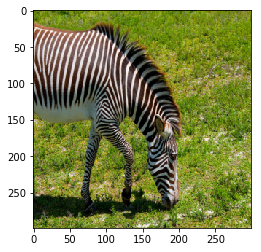

Captions
('A zebra grazing on lush green grass in a field.', 'Zebra reaching its head down to ground where grass is. ', 'The zebra is eating grass in the sun.', 'A lone zebra grazing in some green grass.', 'a Zebra grazing on grass in a green open field.')
NN classes
['zebra', 'gazelle', 'hartebeest', 'impala, Aepyceros melampus', 'African elephant, Loxodonta africana']
# 6


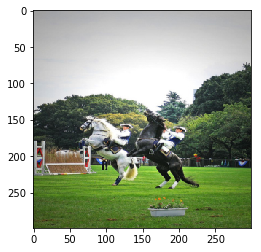

Captions
('A couple of men riding horses on top of a green field.', 'two horses and their riders on some grass', 'Two men are on horses that are reared back.', 'A pair of horses performing tricks in a field. ', 'Two costumed horse riders make their horses stand on their hind legs.')
NN classes
['parachute, chute', 'football helmet', 'radio telescope, radio reflector', 'maypole', 'ballplayer, baseball player']
# 9


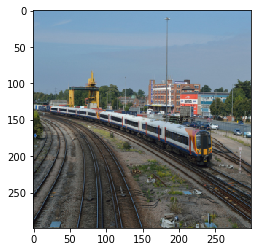

Captions
('A train coming to a stop on the tracks out side.', 'The very long train is travelling down the tracks.', 'A passenger train glides around a curve on the outer track.', 'A train coming down the tracks in the city.', 'A train engine carrying many carts down a track.')
NN classes
['streetcar, tram, tramcar, trolley, trolley car', 'mosque', 'palace', 'dome', 'submarine, pigboat, sub, U-boat']


In [10]:
img_batch, capt_batch = next(iter(data_loader))

# captions batch is transposed in our version. Check if the same is true for yours
capt_batch = list(zip(*capt_batch))
if torch.cuda.is_available():
    img_batch = img_batch.cuda()
with torch.no_grad():
    attn_features_batch, logits_batch  = [var.cpu().numpy() for var in features_net(img_batch)]

print("NN shapes")
print('before_pool:', np.shape(attn_features_batch))
print('logits:', np.shape(logits_batch))


# class labels
import requests
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

for i in range(0, 10, 3):
    print("#", i)
    plt.imshow(img_batch[i].cpu().numpy().transpose([1,2,0]))
    plt.show()
    print('Captions')
    print(capt_batch[i])

    top_ix = (-logits_batch[i]).argsort()
    print('NN classes')
    print(list(map(labels.get, top_ix[:5])))

# Actually transforming data

Usually we cannot store all 18Gb of image codes in RAM, so we store them in a file with a fast access.

Please be sure you have ~20Gb of disk space.

In [11]:
with h5py.File('img_codes.hdf5', 'w') as f:
    obj_shape = (512, 9, 9)
    chunk_size = 128
    img_codes = f.create_dataset('data', (len(coco_train), *obj_shape), dtype='float32',
                                 maxshape=(len(coco_train), *obj_shape),
                                 chunks=(chunk_size, *obj_shape), compression=None)
    pos = 0
    captions = []
    with tqdm(data_loader) as iterator:
        for batches_complete, (img_batch, capt_batch) in enumerate(iterator):
            capt_batch = list(zip(*capt_batch))
            captions.extend(capt_batch)
            
            if torch.cuda.is_available():
                img_batch = img_batch.cuda()
            with torch.no_grad():
                attn_features_batch, logits_batch  = [var.cpu().numpy() for var in features_net(img_batch)]
            img_codes[pos: pos + attn_features_batch.shape[0]] = attn_features_batch
            pos += attn_features_batch.shape[0]

100%|██████████| 3697/3697 [29:33<00:00,  2.50it/s]


In [12]:
# As you can see, reading image codes from file is much faster
# than recomputing them

print('Reading from file:')
f = h5py.File('img_codes.hdf5', 'r')
img_codes = f['data']
i = np.random.randint(3696)
%time img_codes[32 * i: 32 * i]
f.close()

print('\nRecomputing:')
img_batch, capt_batch = next(iter(data_loader))
if torch.cuda.is_available():
    img_batch = img_batch.cuda()
with torch.no_grad():
    %time attn_features_batch, logits_batch  = [var.cpu().numpy() for var in features_net(img_batch)]

Reading from file:
CPU times: user 185 µs, sys: 62 µs, total: 247 µs
Wall time: 252 µs

Recomputing:
CPU times: user 357 ms, sys: 108 ms, total: 465 ms
Wall time: 465 ms


In [13]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

captions_tokenized = [[' '.join(filter(len, tokenizer.tokenize(cap.lower()))) 
                           for cap in img_captions]
                                for img_captions in tqdm(captions)]

100%|██████████| 118287/118287 [00:11<00:00, 10131.06it/s]


In [14]:
i = 123
print("Original:\n%s\n\n" % '\n'.join(captions[i]))
print("Tokenized:\n%s\n\n"% '\n'.join(captions_tokenized[i]))

Original:
A young man riding a skateboard down a ramp.
A person standing on a skateboard and skating at a park.
A teenager riding a skateboard at a skate park.
A man riding a skateboard on a ramp.
A kid on a skate board riding on a ramp.


Tokenized:
a young man riding a skateboard down a ramp .
a person standing on a skateboard and skating at a park .
a teenager riding a skateboard at a skate park .
a man riding a skateboard on a ramp .
a kid on a skate board riding on a ramp .




# Save everything
May take a couple of minutes depending on hdd/sdd speed.

In [15]:
import json
with open('./captions.json', 'w') as f_cap:
    json.dump(captions, f_cap)
with open('./captions_tokenized.json', 'w') as f_cap:
    json.dump(captions_tokenized, f_cap)

In [16]:
# sanity check
!du -h --max-depth=1 .
!ls -lht .

4.6M	./.ipynb_checkpoints
788M	./val2017
19G	./train2017
796M	./annotations
58G	.
total 38G
-rw-rw-r-- 1 oleg oleg  33M Oct 26 19:16 captions_tokenized.json
-rw-rw-r-- 1 oleg oleg  33M Oct 26 19:16 captions.json
-rw-rw-r-- 1 oleg oleg 598K Oct 26 19:15 ht_attention_preprocess_data.ipynb
-rw-rw-r-- 1 oleg oleg  19G Oct 26 19:14 img_codes.hdf5
-rw-rw-r-- 1 oleg oleg 4.1M Oct 26 18:48 ht_attention.ipynb
-rw-rw-r-- 1 oleg oleg 196K Oct 26 18:35 log
drwxrwxr-x 2 oleg oleg 4.0K Oct 26 18:33 annotations
-rw-rw-r-- 1 oleg oleg 242M Oct 26 18:33 annotations_trainval2017.zip
-rw-rw-r-- 1 oleg oleg 778M Oct 26 18:31 val2017.zip
-rw-rw-r-- 1 oleg oleg  19G Oct 26 18:22 train2017.zip
drwxrwxr-x 2 oleg oleg 4.1M Aug 31  2017 train2017
drwxrwxr-x 2 oleg oleg 172K Aug 31  2017 val2017
